In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
#plt.rcParams["font.family"]="Arial"
plt.rcParams["pdf.fonttype"]= 42

In [3]:
selection = pd.read_csv('/media/scPBMC1_AnalysisDisk1/huangzhuoli/hw5_backup/huangzhuoli/genetics_Data/chinese_selection_list_full.csv',header = 0)
selection.index = selection['site_38']

In [4]:
eQTL_result = pd.read_csv('/CIMA/Result/20250108_cis_eQTL_studywise_sig.csv',header = 0,index_col=0)

In [5]:
eQTL_selection_summary = pd.DataFrame()
for celltype in eQTL_result['celltype'].unique():
    eQTL_result_use = eQTL_result[eQTL_result['celltype'] == celltype]
    isindf = pd.DataFrame({celltype:selection['site_38'].isin(eQTL_result_use['variant_id'])})
    eQTL_selection_summary = pd.concat([eQTL_selection_summary,isindf],axis=1)
    eQTL_selection_summary = eQTL_selection_summary.astype(int)

In [6]:
caQTL_result = pd.read_csv('/CIMA/Result/20250108_cis_caQTL_studywise_sig.csv',header = 0,index_col=0)

In [7]:
caQTL_selection_summary = pd.DataFrame()
for celltype in caQTL_result['celltype'].unique():
    caQTL_result_use = caQTL_result[caQTL_result['celltype'] == celltype]
    isindf = pd.DataFrame({celltype:selection['site_38'].isin(caQTL_result_use['variant_id'])})
    caQTL_selection_summary = pd.concat([caQTL_selection_summary,isindf],axis=1)
    caQTL_selection_summary = caQTL_selection_summary.astype(int)

In [8]:
def remove_zero_rows_and_cols(df):
    """
    删除数据框中所有行为0的列和所有列为0的行。

    参数：
    - df：DataFrame，要处理的数据框。

    返回值：
    删除零行零列后的新数据框。
    """
    # 删除所有列为0的行
    df = df.loc[(df != 0).any(axis=1)]

    # 删除所有行为0的列
    df = df.loc[:, (df != 0).any(axis=0)]

    return df

In [9]:
caQTL_selection_summary_1 = remove_zero_rows_and_cols(caQTL_selection_summary)
eQTL_selection_summary_1 = remove_zero_rows_and_cols(eQTL_selection_summary)
# Take the union of indices
union_index = eQTL_selection_summary_1.index.union(caQTL_selection_summary_1.index)
union_column = eQTL_selection_summary_1.columns.union(caQTL_selection_summary_1.columns)

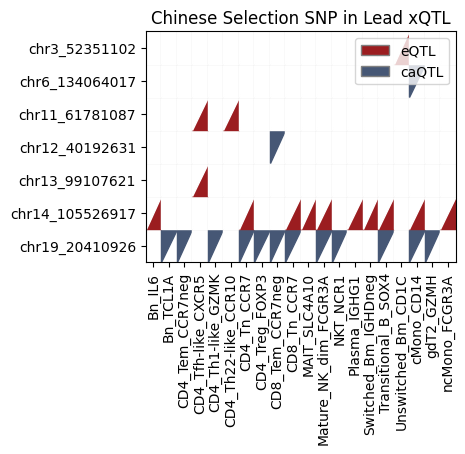

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from natsort import natsorted

eQTL_df = eQTL_selection_summary.loc[union_index,union_column]
eQTL_df = eQTL_df.loc[natsorted(eQTL_df.index),:]
eQTL_df = eQTL_df.iloc[::-1,:]
caQTL_df = eQTL_df.copy()
caQTL_df.iloc[:, :] = 0

for column in caQTL_selection_summary_1.columns:
    for rowname in caQTL_selection_summary_1.index:
        caQTL_df.loc[rowname,column] = caQTL_selection_summary_1.loc[rowname,column]

fig, ax = plt.subplots(figsize=(4, 3))

# Normalize data to [0, 1]
norm1 = mcolors.Normalize(vmin=0, vmax=eQTL_df.max().max())
norm2 = mcolors.Normalize(vmin=0, vmax=caQTL_df.max().max())

# Loop through each cell and plot two triangles
for i, row in enumerate(eQTL_df.index):
    for j, col in enumerate(eQTL_df.columns):
        value1 = eQTL_df.loc[row, col]
        value2 = caQTL_df.loc[row, col]
        
        # Define the rectangle for the cell
        rect = patches.Rectangle((j, i), 1, 1, linewidth=0.8, edgecolor='gray', facecolor='none')
        ax.add_patch(rect)
        
        # Define vertices for the two triangles, swapping the diagonal direction
        vertices1 = np.array([[j, i], [j + 1, i], [j + 1, i + 1]])  # Triangle 1
        vertices2 = np.array([[j, i], [j, i + 1], [j + 1, i + 1]])  # Triangle 2
        
        # Plot the two triangles with colors determined by data values
        if value1 != 0:
            ax.fill(vertices1[:, 0], vertices1[:, 1], color='#9B1D20')
        else:
            ax.fill(vertices1[:, 0], vertices1[:, 1], color='white')
        
        if value2 != 0:
            ax.fill(vertices2[:, 0], vertices2[:, 1], color='#465775')#blue
        else:
            ax.fill(vertices2[:, 0], vertices2[:, 1], color='white')
            
# Set labels and title
#ax.set_xlabel('Trait')
#ax.set_ylabel('Celltype')
ax.set_title('Chinese Selection SNP in Lead xQTL')

# Set axis limits
ax.set_xlim(0, eQTL_df.shape[1])
ax.set_ylim(0, eQTL_df.shape[0])

# Set tick labels
ax.set_xticks(np.arange(eQTL_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(eQTL_df.shape[0]) + 0.5)
ax.set_xticklabels(eQTL_df.columns, rotation=90)
ax.set_yticklabels(eQTL_df.index)

# 添加图例
legend_elements = [
    patches.Patch(facecolor='#9B1D20', edgecolor='gray', label='eQTL'),
    patches.Patch(facecolor='#465775', edgecolor='gray', label='caQTL')
]
ax.legend(handles=legend_elements, loc='upper right')
                    
plt.savefig('/CIMA/Result/plot/20250318_selection_in_QTL.pdf', bbox_inches='tight')
plt.show()